### Parametry do optymalizacji:
- minimalna powierzchnia *min_size*,
- minimalny dystans między polygonami *cluster_max_dist*,
- dodatkowe filtrowanie klastrów *min_polygon_num*, *min_size* (po liczbie polygonów i ich polu),
- concave (wtedy jaki parametr, chyba można dla każdego liczyć parametr, aż pole hull będzie niemniejsze niż suma pól polygonów), convex czy jeszcze coś innego,

### Inne
- w którychś momentach trzeba odjąć zakazane i dodać margines

- miejsce parkingowe ma 5m x 2.5m

In [2]:
import json
import cv2
import numpy as np
import os
from shapely.geometry import Polygon, MultiPolygon
from collections import deque
import matplotlib.pyplot as plt

In [3]:
def bfs_split_mask(mask):
    rows, cols, *_ = mask.shape
    binary_mask = np.zeros((rows, cols))
    binary_mask[mask[:, :, 3] > 0] = 1
    visited = np.zeros_like(binary_mask, dtype=bool)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    regions = []

    for r in range(rows):
        for c in range(cols):
            if binary_mask[r, c] == 1 and not visited[r, c]:
                region = np.zeros_like(binary_mask, dtype=np.uint8)
                queue = deque([(r, c)])
                visited[r, c] = True

                while queue:
                    x, y = queue.popleft()
                    region[x, y] = 1

                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < rows and 0 <= ny < cols and binary_mask[nx, ny] == 1 and not visited[nx, ny]:
                            queue.append((nx, ny))
                            visited[nx, ny] = True

                regions.append(region)

    return regions

def regions_to_polygons(regions):
    polygons = []
    for region in regions:
        contours, _ = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            coords = [(point[0][0], point[0][1]) for point in contour]

            if len(coords) < 3:
                continue

            polygon = Polygon(coords)

            if polygon.is_valid and polygon.area > 0:
                polygons.append(polygon)
            elif polygon.buffer(0).is_valid:
                polygon = polygon.buffer(0)
                if isinstance(polygon, MultiPolygon):
                    for polygon_split in list(polygon.geoms):
                        polygons.append(polygon_split)
                else:
                    polygons.append(polygon.buffer(0))

    return polygons

### Load homography info

In [4]:
info_path = r'C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\homography_info'
with open(os.path.join(info_path, 'info.json'), 'r') as info_file:
    homography_info = json.load(info_file)

H1 = np.load(os.path.join(info_path, homography_info['cameras']['weti1']['filename']))
H2 = np.load(os.path.join(info_path, homography_info['cameras']['weti2']['filename']))
H12 = np.load(os.path.join(info_path, homography_info['cameras']['weti1_weti2']['filename']))

homography = {
    'weti1': H1,
    'weti2': H2,
    'weti1_weti2': H12
}

### Load masks

In [5]:
camera_ids = ['weti1', 'weti2']
# loading masks
camera_masks = {
    cid: {
        'allowed': cv2.imread(os.path.join(info_path, f"allowed_{cid}.png"), cv2.IMREAD_UNCHANGED),
        'forbidden': cv2.imread(os.path.join(info_path, f"forbidden_{cid}.png"), cv2.IMREAD_UNCHANGED)
    } for cid in camera_ids
}

# crop to top left corner
for cid in camera_ids:
    offx, offy = homography_info['cameras'][cid]['offset']
    camera_masks[cid]['allowed'] = camera_masks[cid]['allowed'][offy:, offx:]
    camera_masks[cid]['forbidden'] = camera_masks[cid]['forbidden'][offy:, offx:]

### Transform masks to polygons

In [6]:
def transform_point(point, H):
    point = np.array([*point, 1])
    transformed_point = np.dot(H, point)
    transformed_point /= transformed_point[2]
    return transformed_point[:2]

def transform_polygon(polygon, H, scale=1):
    transformed_points = [transform_point(p, H) * scale for p in np.array(polygon.exterior.coords)]
    return Polygon(transformed_points)

def filter_polygons(polygons: list[Polygon], min_size=5):
    return [p for p in polygons if p.area > min_size]

In [7]:
# masks to separate regions
camera_polygons = {
    cid: {
        'allowed': regions_to_polygons(bfs_split_mask(camera_masks[cid]['allowed'])),
        'forbidden': regions_to_polygons(bfs_split_mask(camera_masks[cid]['forbidden']))
    } for cid in camera_ids
}

In [8]:
# regions to polygons with area filter
camera_polygons_transformed = {
    cid: {
        'allowed': filter_polygons([transform_polygon(poly, homography[cid]) for poly in camera_polygons[cid]['allowed']], min_size=8),
        'forbidden': filter_polygons([transform_polygon(poly, homography[cid]) for poly in camera_polygons[cid]['forbidden']], min_size=8)
    } for cid in camera_ids
}

In [9]:
# merging two cameras
# weti1 to weti2
cid = 'weti1'
hid = 'weti1_weti2'
camera_polygons_transformed[cid] = {
    'allowed': [transform_polygon(poly, homography[hid]) for poly in camera_polygons_transformed[cid]['allowed']],
    'forbidden': [transform_polygon(poly, homography[hid]) for poly in camera_polygons_transformed[cid]['forbidden']]
}

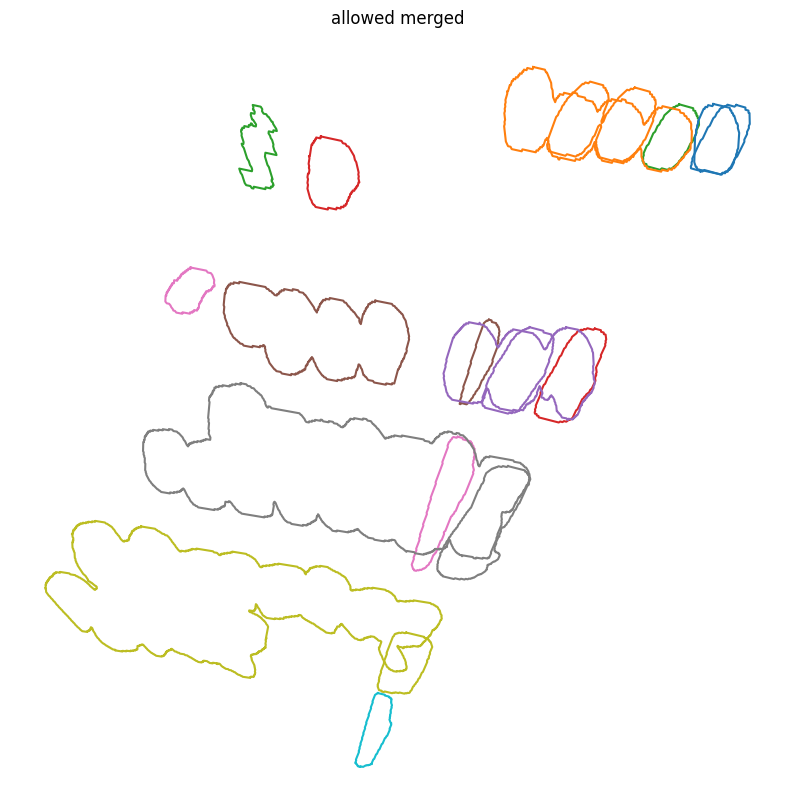

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

for poly in camera_polygons_transformed['weti1']['allowed']:
    ax.plot(*poly.exterior.xy)
for poly in camera_polygons_transformed['weti2']['allowed']:
    ax.plot(*poly.exterior.xy)

ax.set_title("Separate Regions")
plt.axis("off")
plt.title('allowed merged')
plt.show()

42.956493919323634
374.3090137781298
91.68907591811663
113.68929993344385
45.89782811466552
724.7354868622637
70.22800931773698
42.308425001013276
30.490034245088314


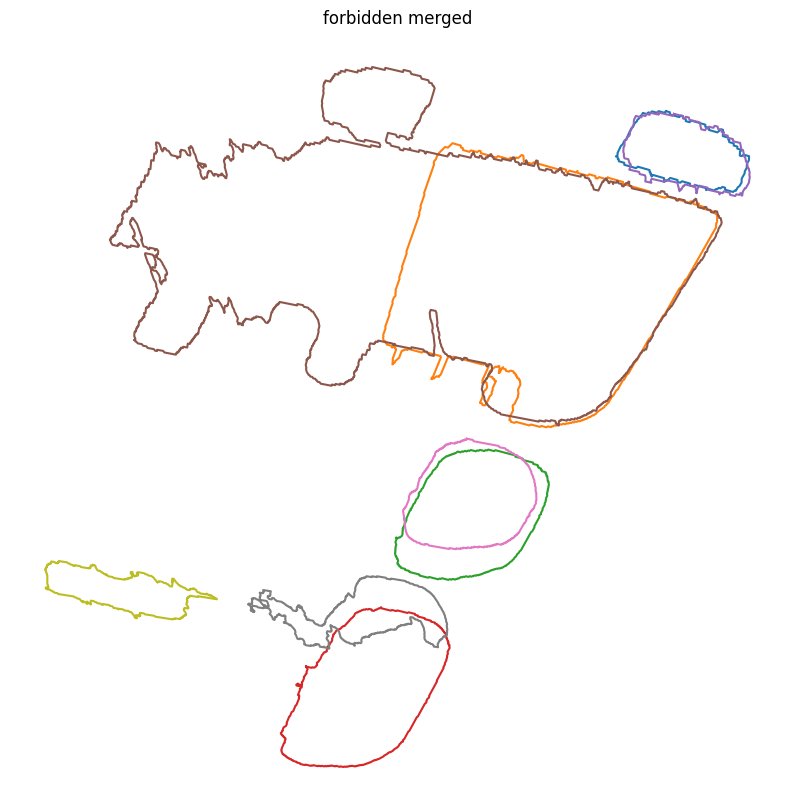

In [11]:
area_f_threshold = 1
fig, ax = plt.subplots(figsize=(10, 10))

for poly in camera_polygons_transformed['weti1']['forbidden']:
    print(poly.area)
    if poly.area > area_f_threshold:
        ax.plot(*poly.exterior.xy)
for poly in camera_polygons_transformed['weti2']['forbidden']:
    print(poly.area)
    if poly.area > area_f_threshold:
        ax.plot(*poly.exterior.xy)

ax.set_title("Separate Regions")
plt.axis("off")
plt.title('forbidden merged')
plt.show()

### Subtracting forbidden [v1]

In [43]:
def sub_polygons(base_polygon, sub_polygons):
    diff = base_polygon
    for sub_poly in sub_polygons:
        diff = diff.difference(sub_poly)
    return diff

def fix_multipolygons(polygons_list):
    polygons_list_fixed = []
    for poly in polygons_list:
        if isinstance(poly, MultiPolygon):
            for p in poly.geoms:
                polygons_list_fixed.append(p)
        else:
            polygons_list_fixed.append(poly)
    return polygons_list_fixed

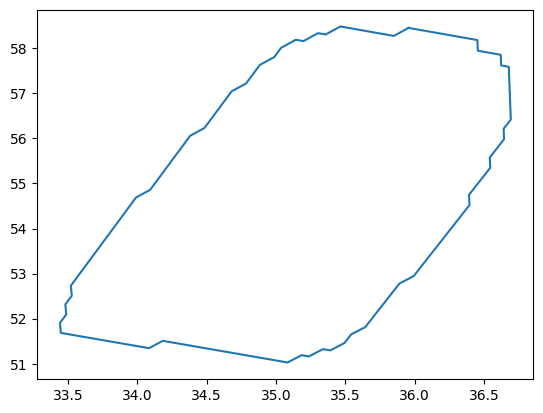

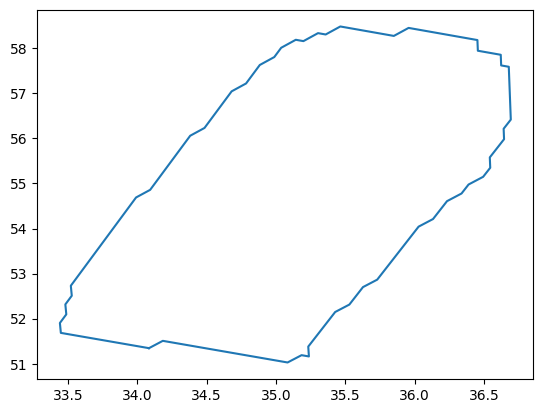

In [34]:
base_allowed = camera_polygons_transformed['weti1']['allowed'][0]
sub_forbidden = camera_polygons_transformed['weti1']['forbidden']
base_res = sub_polygons(base_allowed, sub_forbidden)
plt.plot(*base_allowed.exterior.xy)
plt.show()
plt.plot(*base_res.exterior.xy)
plt.show()

In [44]:
allowed_subtracted = []
all_forbidden = sum([camera_polygons_transformed[k]['forbidden'] for k in camera_polygons_transformed], [])
for k in camera_polygons_transformed:
    for allowed_poly in camera_polygons_transformed[k]['allowed']:
        allowed_subtracted.append(sub_polygons(allowed_poly, camera_polygons_transformed[k]['forbidden'])) #all_forbidden))
allowed_subtracted = fix_multipolygons(allowed_subtracted)

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'sha

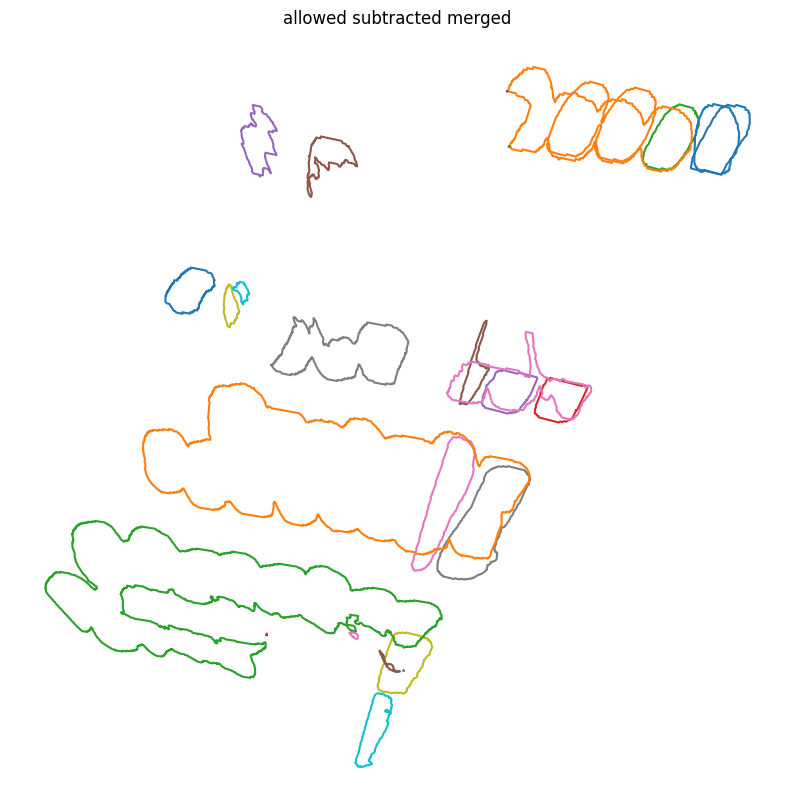

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

for poly in allowed_subtracted:
    print(type(poly))
    if isinstance(poly, MultiPolygon):
        print(poly.geoms)
        for p in poly.geoms:
            ax.plot(*p.exterior.xy)
    else:
        ax.plot(*poly.exterior.xy)

ax.set_title("Separate Regions")
plt.axis("off")
plt.title('allowed subtracted merged')
plt.show()

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>


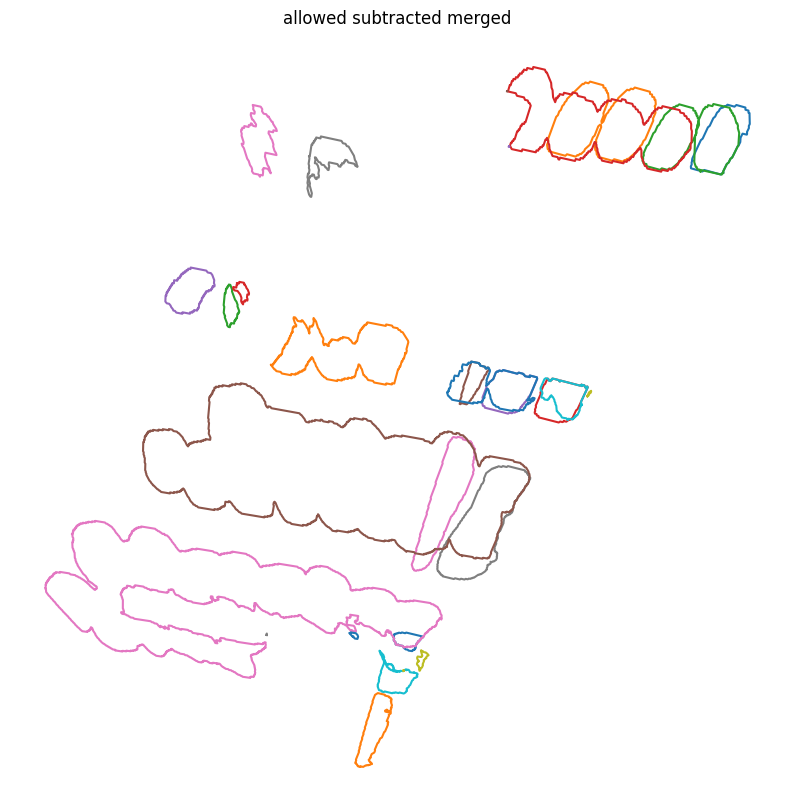

In [32]:
# subtracted all forbidden polygons
fig, ax = plt.subplots(figsize=(10, 10))

for poly in allowed_subtracted:
    print(type(poly))
    if isinstance(poly, MultiPolygon):
        print(poly.geoms)
        for p in poly.geoms:
            ax.plot(*p.exterior.xy)
    else:
        ax.plot(*poly.exterior.xy)

ax.set_title("Separate Regions")
plt.axis("off")
plt.title('allowed subtracted merged')
plt.show()

### Allowed polygons to clusters

In [41]:
from sklearn.cluster import DBSCAN

def polygon_distance_matrix(polygons):
    n = len(polygons)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = polygons[i].distance(polygons[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

In [46]:
cluster_max_dist = 0.5 
all_allowed_polygons = allowed_subtracted#sum([camera_polygons_transformed[cid]['allowed'] for cid in camera_polygons_transformed], [])

distance_matrix = polygon_distance_matrix(all_allowed_polygons)

dbscan = DBSCAN(eps=cluster_max_dist, min_samples=1, metric="precomputed")
labels = dbscan.fit_predict(distance_matrix)
clustered_polygons = [[all_allowed_polygons[i] for i in range(len(all_allowed_polygons)) if labels[i] == cluster_id] for cluster_id in set(labels)]

for i, cluster in enumerate(clustered_polygons):
    print(f"cluster {i+1}. {[list(poly.exterior.coords) for poly in cluster]}")

cluster 1. [[(34.0833614125508, 51.34440288586196), (33.447444363345525, 51.68347473899516), (33.44052987307172, 51.903102440095005), (33.48676352251646, 52.09491143870293), (33.47988183684807, 52.31560507049566), (33.526277548913015, 52.50838723410548), (33.51942907864806, 52.730154681292554), (33.990142978545975, 54.689112739964244), (34.091889848659605, 54.8586036238623), (34.380976287287886, 56.059807498716154), (34.484053272557155, 56.23235571521069), (34.679908158978954, 57.04489658291623), (34.783970580946345, 57.21966471482643), (34.883004856525105, 57.6298867939017), (34.98768963564848, 57.80598819228906), (35.03758158987272, 58.01233018396194), (35.14270419815922, 58.18931302435558), (35.19780275080285, 58.15944180520259), (35.30323284937007, 58.33679698467832), (35.35838235004605, 58.306882536786986), (35.464121052910215, 58.48461127981093), (35.850370414585285, 58.274990511395906), (35.95676949626258, 58.45280946190073), (36.45337180900565, 58.18315793910557), (36.456606586

In [47]:
clustered_polygons[0]

[<POLYGON ((34.083 51.344, 33.447 51.683, 33.441 51.903, 33.487 52.095, 33.48...>,
 <POLYGON ((31.308 59.332, 31.418 59.272, 31.428 59.034, 31.483 59.004, 31.50...>,
 <POLYGON ((33.694 57.578, 33.748 57.548, 33.755 57.314, 33.81 57.284, 33.817...>,
 <POLYGON ((35.195 51.214, 35.144 51.011, 34.023 51.494, 33.974 51.291, 33.93...>,
 <POLYGON ((25.743 60.312, 25.802 60.039, 25.83 59.29, 25.945 58.753, 26.023 ...>,
 <POLYGON ((23.39 54.03, 23.39 54.03, 23.425 54.015, 23.39 54.03))>,
 <POLYGON ((23.287 59.923, 23.314 59.911, 23.287 59.923, 23.287 59.923))>]

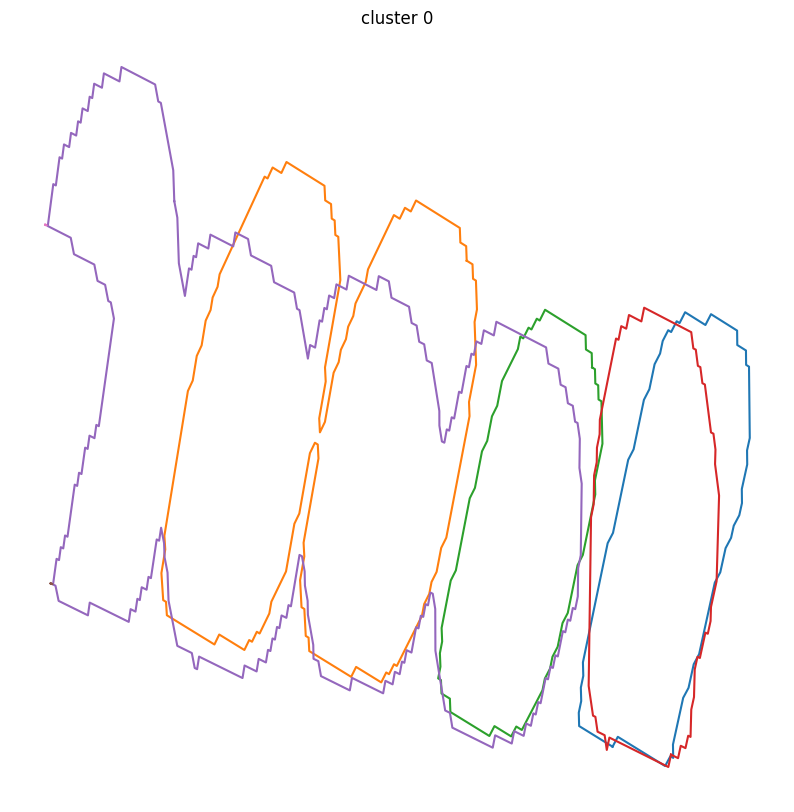

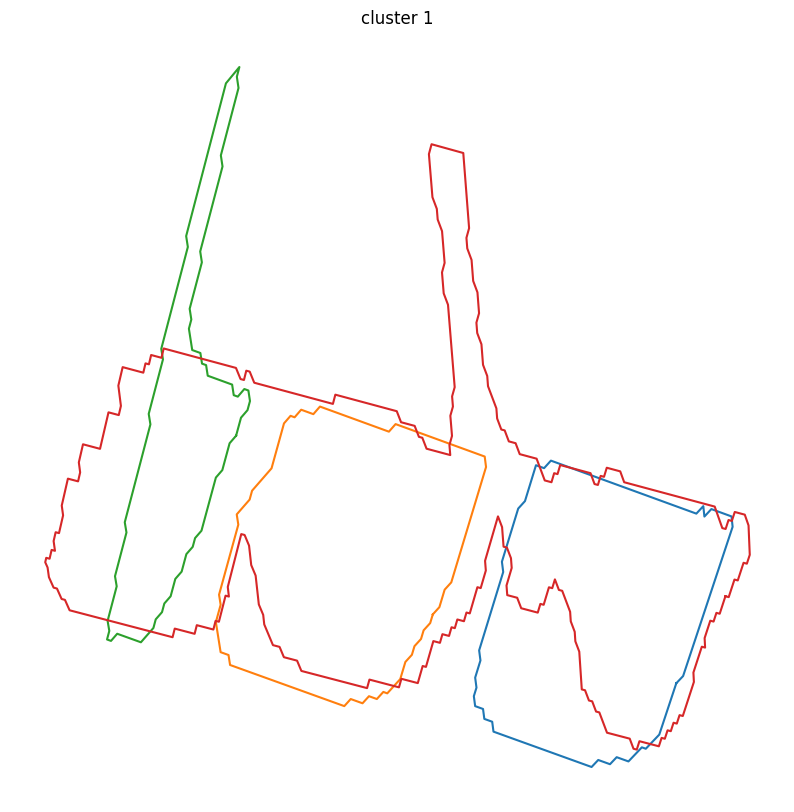

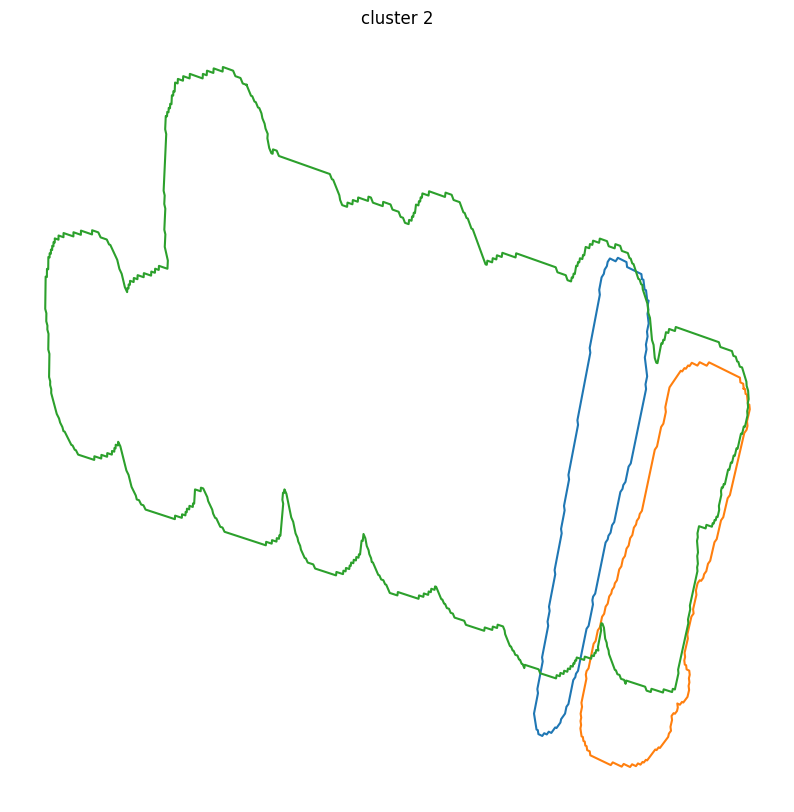

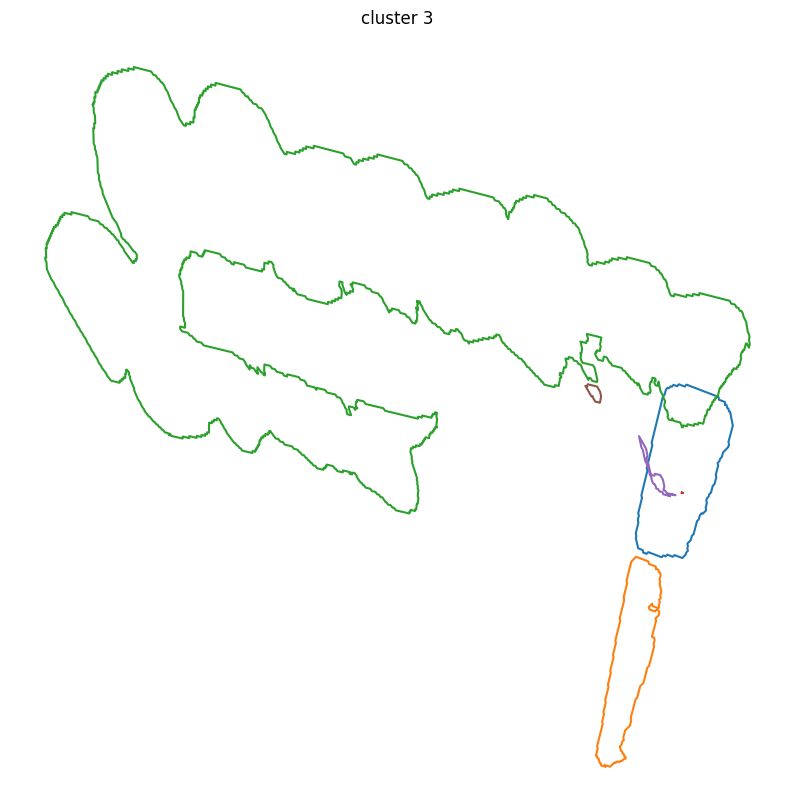

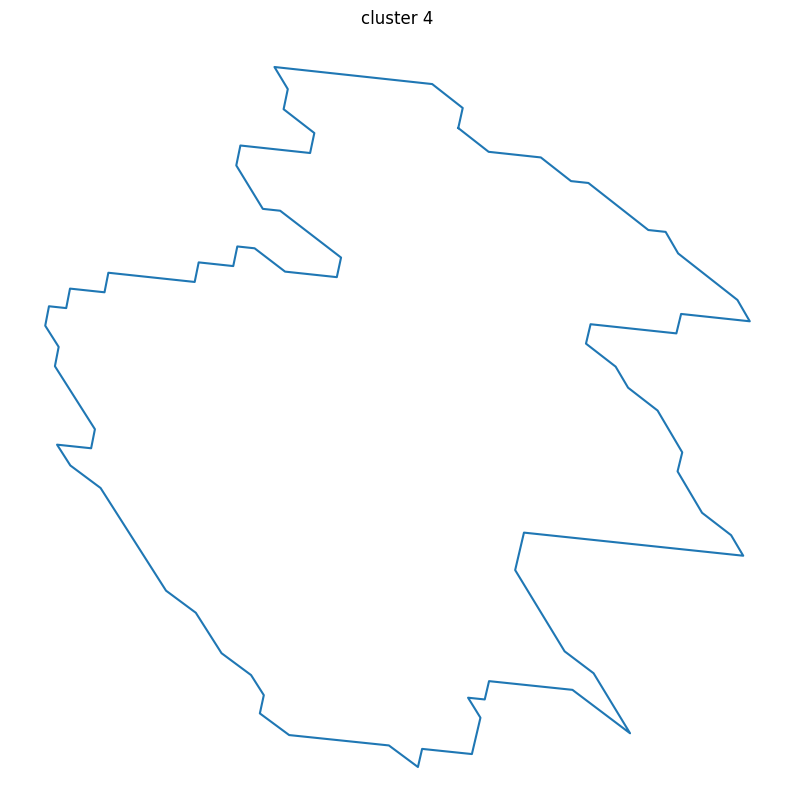

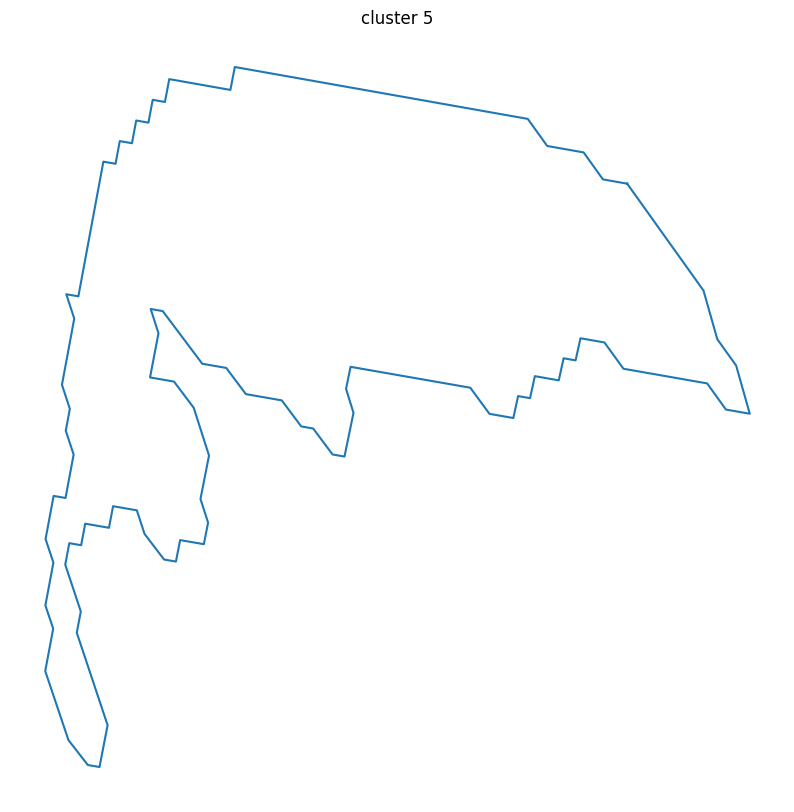

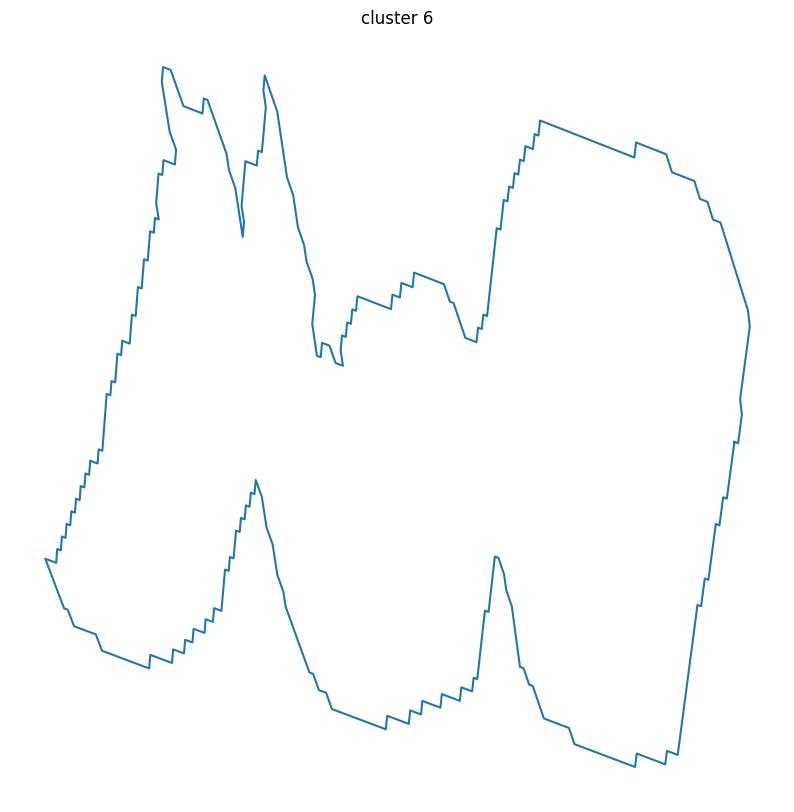

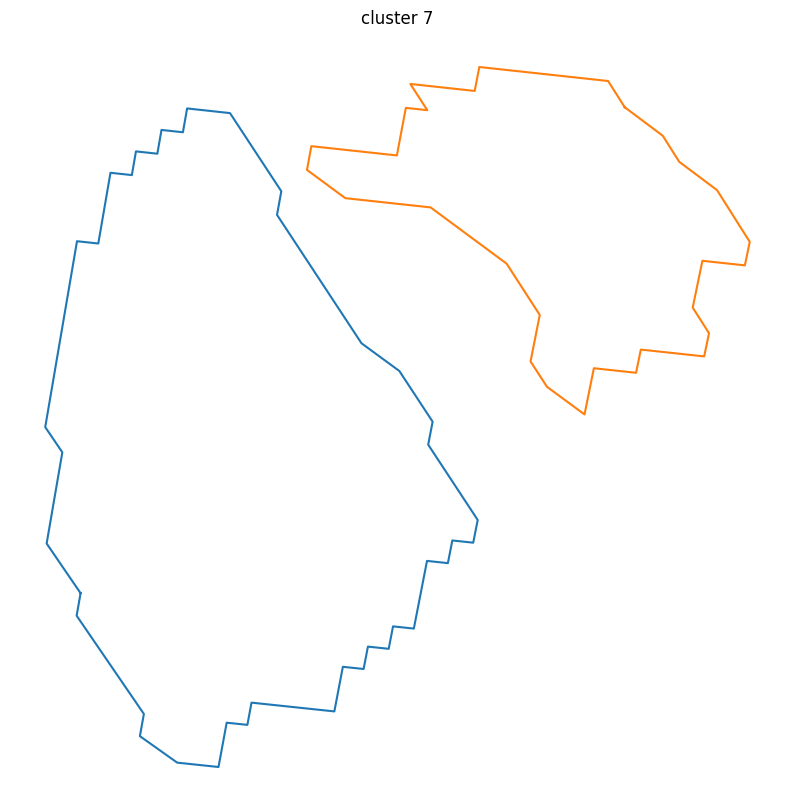

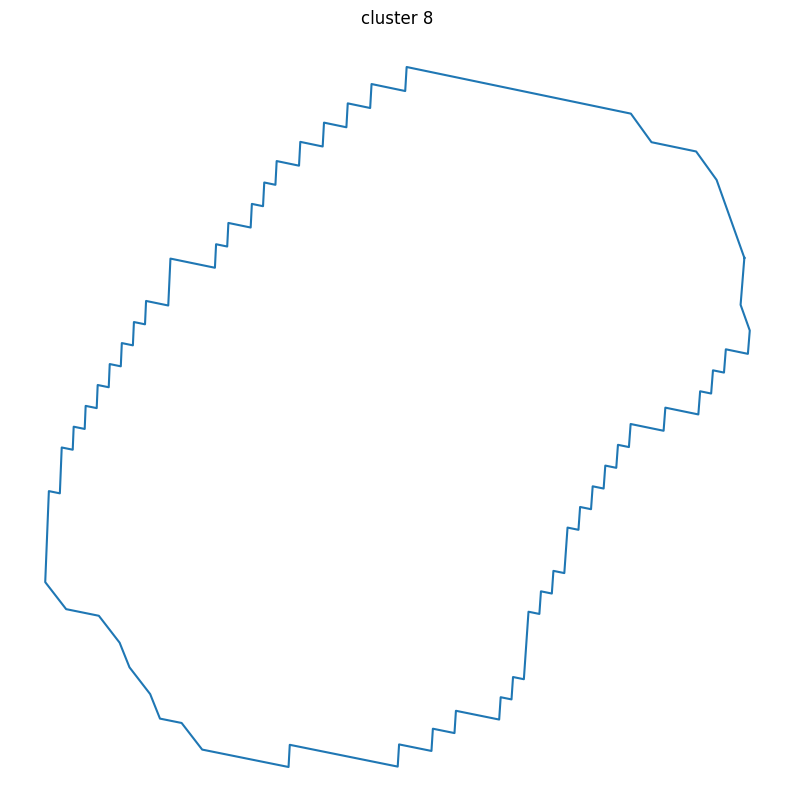

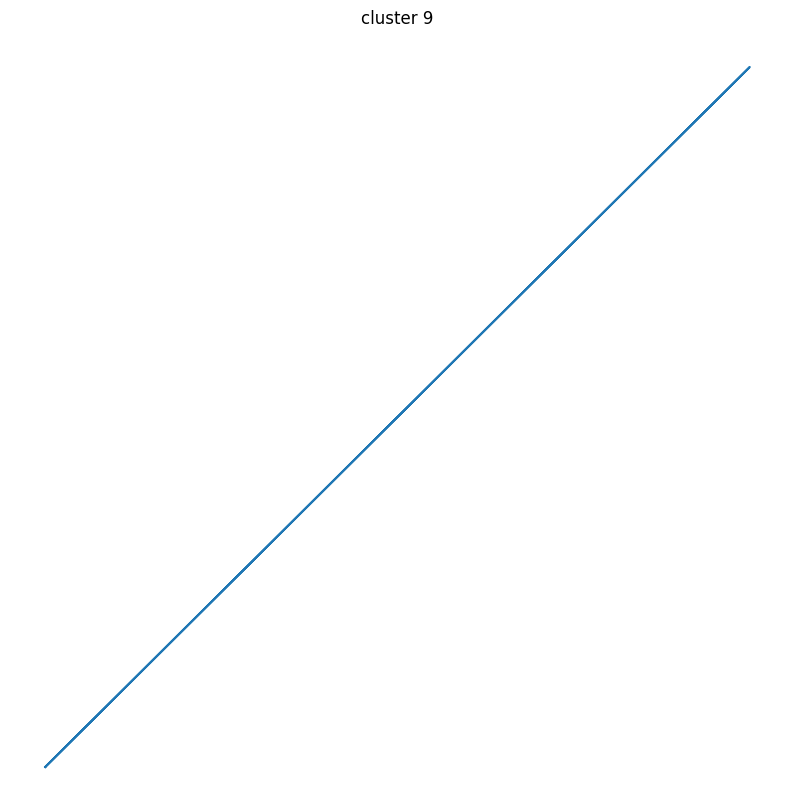

In [49]:
for cluster_id, cluster in enumerate(clustered_polygons):
    area_f_threshold = 1
    fig, ax = plt.subplots(figsize=(10, 10))

    for poly in cluster:
        ax.plot(*poly.exterior.xy)

    ax.set_title("Separate Regions")
    plt.axis("off")
    plt.title(f'cluster {cluster_id}')
    plt.show()

### Subtracting forbidden [v2]

In [ ]:
# chyba nie trzeba

### Merging allowed
raczej po prostu convex_hull 

In [56]:
from shapely import GeometryCollection, MultiPolygon, concave_hull

def merge_clusters(clustered_polygons, mode='convex', hull_param=0.5):
    merged_clusters = []
    for cluster in clustered_polygons:
        print("cluster size:", len(cluster))
        collection = GeometryCollection(cluster)
        if mode == 'concave':
            merged_clusters.append(concave_hull(collection, hull_param))
        elif mode == 'convex':
            merged_clusters.append(collection.convex_hull)
    return merged_clusters

def filter_clusters(clustered_polygons, min_polygon_num=0, min_size=0):
    return [cp for cp in clustered_polygons if len(cp) >= min_polygon_num and MultiPolygon(cp).area >= min_size]

cluster size: 7
cluster size: 4
cluster size: 3
cluster size: 6
cluster size: 1


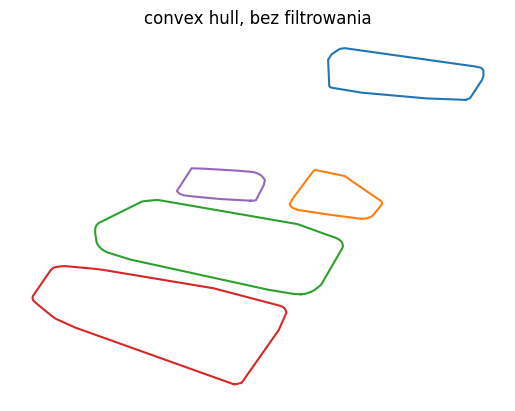

In [57]:
merged_clusters = merge_clusters(filter_clusters(clustered_polygons, min_size=5*2.5))

for poly in merged_clusters:
    plt.plot(*poly.exterior.xy)

# for poly in camera_polygons_transformed['weti1']['allowed']:
#     plt.plot(*poly.exterior.xy)
# for poly in camera_polygons_transformed['weti2']['allowed']:
#     plt.plot(*poly.exterior.xy)

plt.axis("off")
plt.title(f'convex hull, bez filtrowania')
plt.show()

cluster size: 7
cluster size: 4
cluster size: 3
cluster size: 6
cluster size: 1


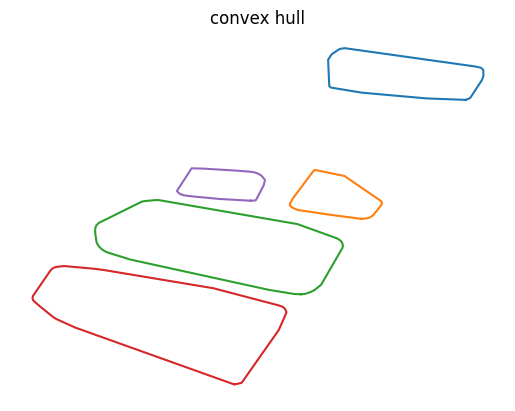

In [68]:
merged_clusters = merge_clusters(filter_clusters(clustered_polygons, min_size=5*2.5))

for poly in merged_clusters:
    plt.plot(*poly.exterior.xy)

# for poly in camera_polygons_transformed['weti1']['allowed']:
#     plt.plot(*poly.exterior.xy)
# for poly in camera_polygons_transformed['weti2']['allowed']:
#     plt.plot(*poly.exterior.xy)

plt.axis("off")
plt.title(f'convex hull')
plt.show()

cluster size: 7
cluster size: 4
cluster size: 3
cluster size: 6
cluster size: 1


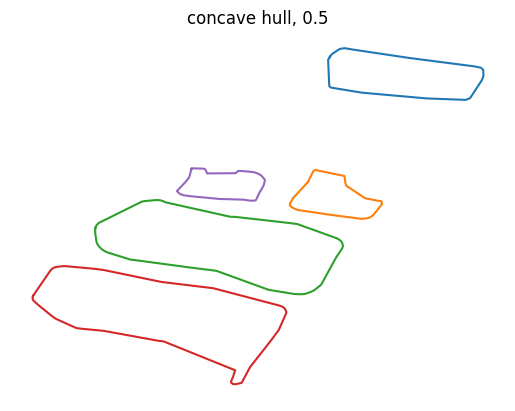

In [65]:
merged_clusters = merge_clusters(filter_clusters(clustered_polygons, min_size=5*2.5), 'concave', 0.5)

for poly in merged_clusters:
    plt.plot(*poly.exterior.xy)

# for poly in camera_polygons_transformed['weti1']['allowed']:
#     plt.plot(*poly.exterior.xy)
# for poly in camera_polygons_transformed['weti2']['allowed']:
#     plt.plot(*poly.exterior.xy)

plt.axis("off")
plt.title(f'concave hull, 0.5')
plt.show()

cluster size: 7
cluster size: 4
cluster size: 3
cluster size: 6
cluster size: 1


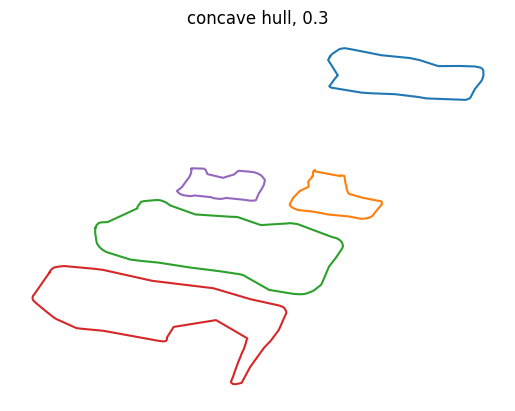

In [67]:
merged_clusters = merge_clusters(filter_clusters(clustered_polygons, min_size=5*2.5), 'concave', 0.3)

for poly in merged_clusters:
    plt.plot(*poly.exterior.xy)

# for poly in camera_polygons_transformed['weti1']['allowed']:
#     plt.plot(*poly.exterior.xy)
# for poly in camera_polygons_transformed['weti2']['allowed']:
#     plt.plot(*poly.exterior.xy)

plt.axis("off")
plt.title(f'concave hull, 0.3')
plt.show()

### Save polygons

In [99]:
poly_dict = {}
for poly_num, poly in enumerate(merged_clusters):
    poly_coords = [[x, y] for x, y in zip(*poly.exterior.xy)]
    poly_dict[poly_num] = poly_coords

with open("parking_area.json", 'w+') as poly_file:
    json.dump(poly_dict, poly_file, indent=4)